In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from math import sqrt
from pandas import DataFrame, melt
#가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

#분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

#사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_gameshowell, pairwise_tests



In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('head_size')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/head_size.xlsx
[desc] 3명의 태아를 대상으로 3명의 관측자가 측정한 태아의 머리 둘레 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (60, 4)
열 개수: 4
행 개수: 60

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   측정자번호   60 non-null     int64  
 1   1번태아    60 non-null     float64
 2   2번태아    60 non-null     float64
 3   3번태아    60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB
None


,측정자번호,1번태아,2번태아,3번태아
0,1,14.9,19.7,13.0
1,1,14.4,20.7,13.5
2,1,14.4,19.9,13.2
3,1,15.1,20.2,12.8
4,1,15.4,19.4,13.8


In [4]:
df = melt(origin, id_vars='측정자번호',
          value_vars=['1번태아', '2번태아','3번태아'],
          var_name = '태아번호', value_name='머리둘레')

df.head()

,측정자번호,태아번호,머리둘레
0,1,1번태아,14.9
1,1,1번태아,14.4
2,1,1번태아,14.4
3,1,1번태아,15.1
4,1,1번태아,15.4


측정자별 태아에 따른 머리 둘레 비교

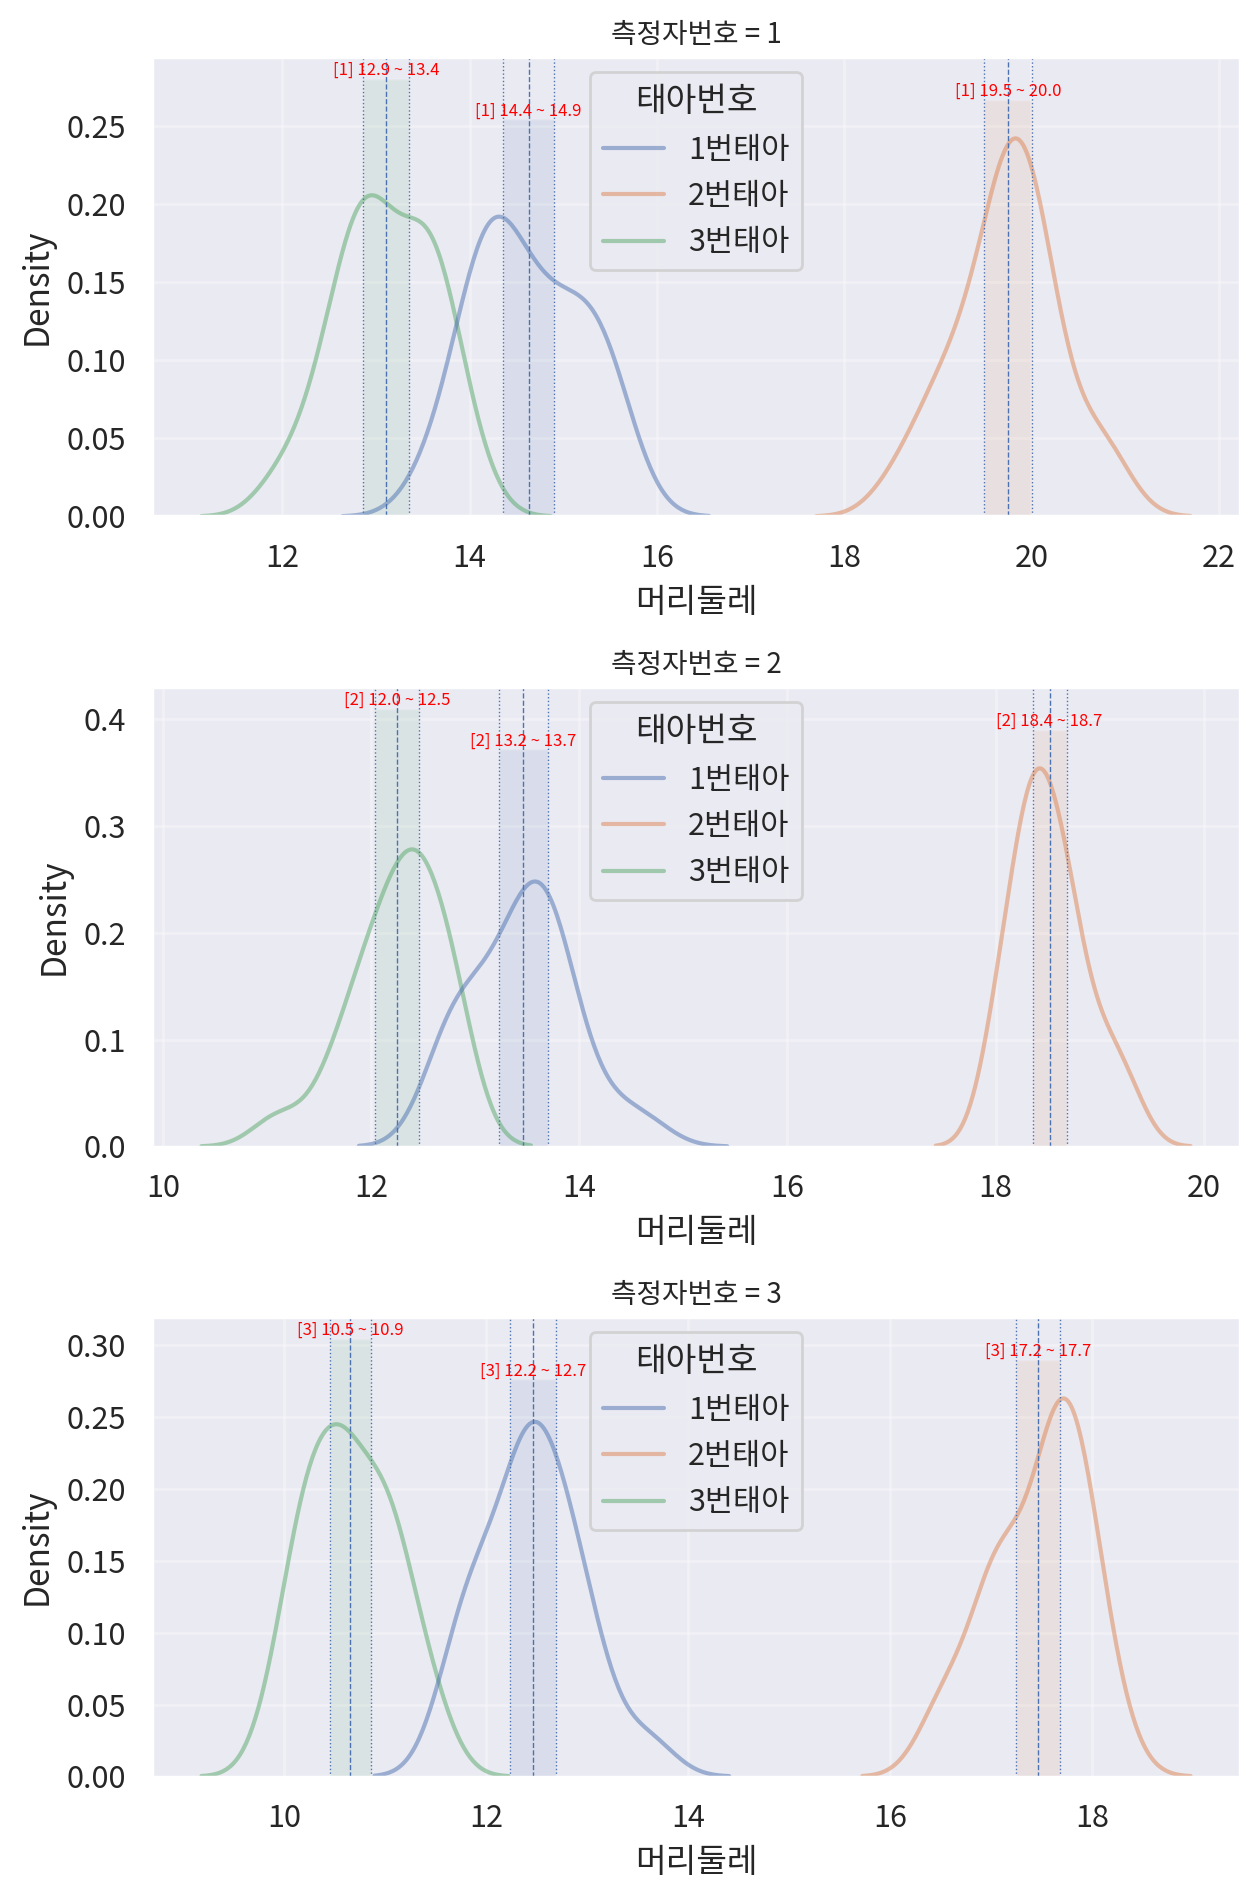

In [5]:
field = '머리둘레'
group_field = '측정자번호'
hue_field = '태아번호'

data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
rows = group_count               #도화지의 행 수
cols = 1                    #도화지의 열 수
width_px = 1280 * cols            #그래프 가로 크기
height_px = 640 * rows             #그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(group_values):
    temp = data[data[group_field]==v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field]==h]

        # 신뢰구간
        max = temp_sub[field].max()                         #최대값
        clevel = 0.95                               #신뢰수준
        dof = len(temp_sub[field]) - 1                       #자유도
        sp_mean = temp_sub[field].mean()                    #표본평균
        sp_std = temp_sub[field].std(ddof = 1)           #표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field])) #표본표준오차
        cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        #평균 표시
        ymin,ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

        #텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료



태아별 측정자에 따른 머리 둘레 비교

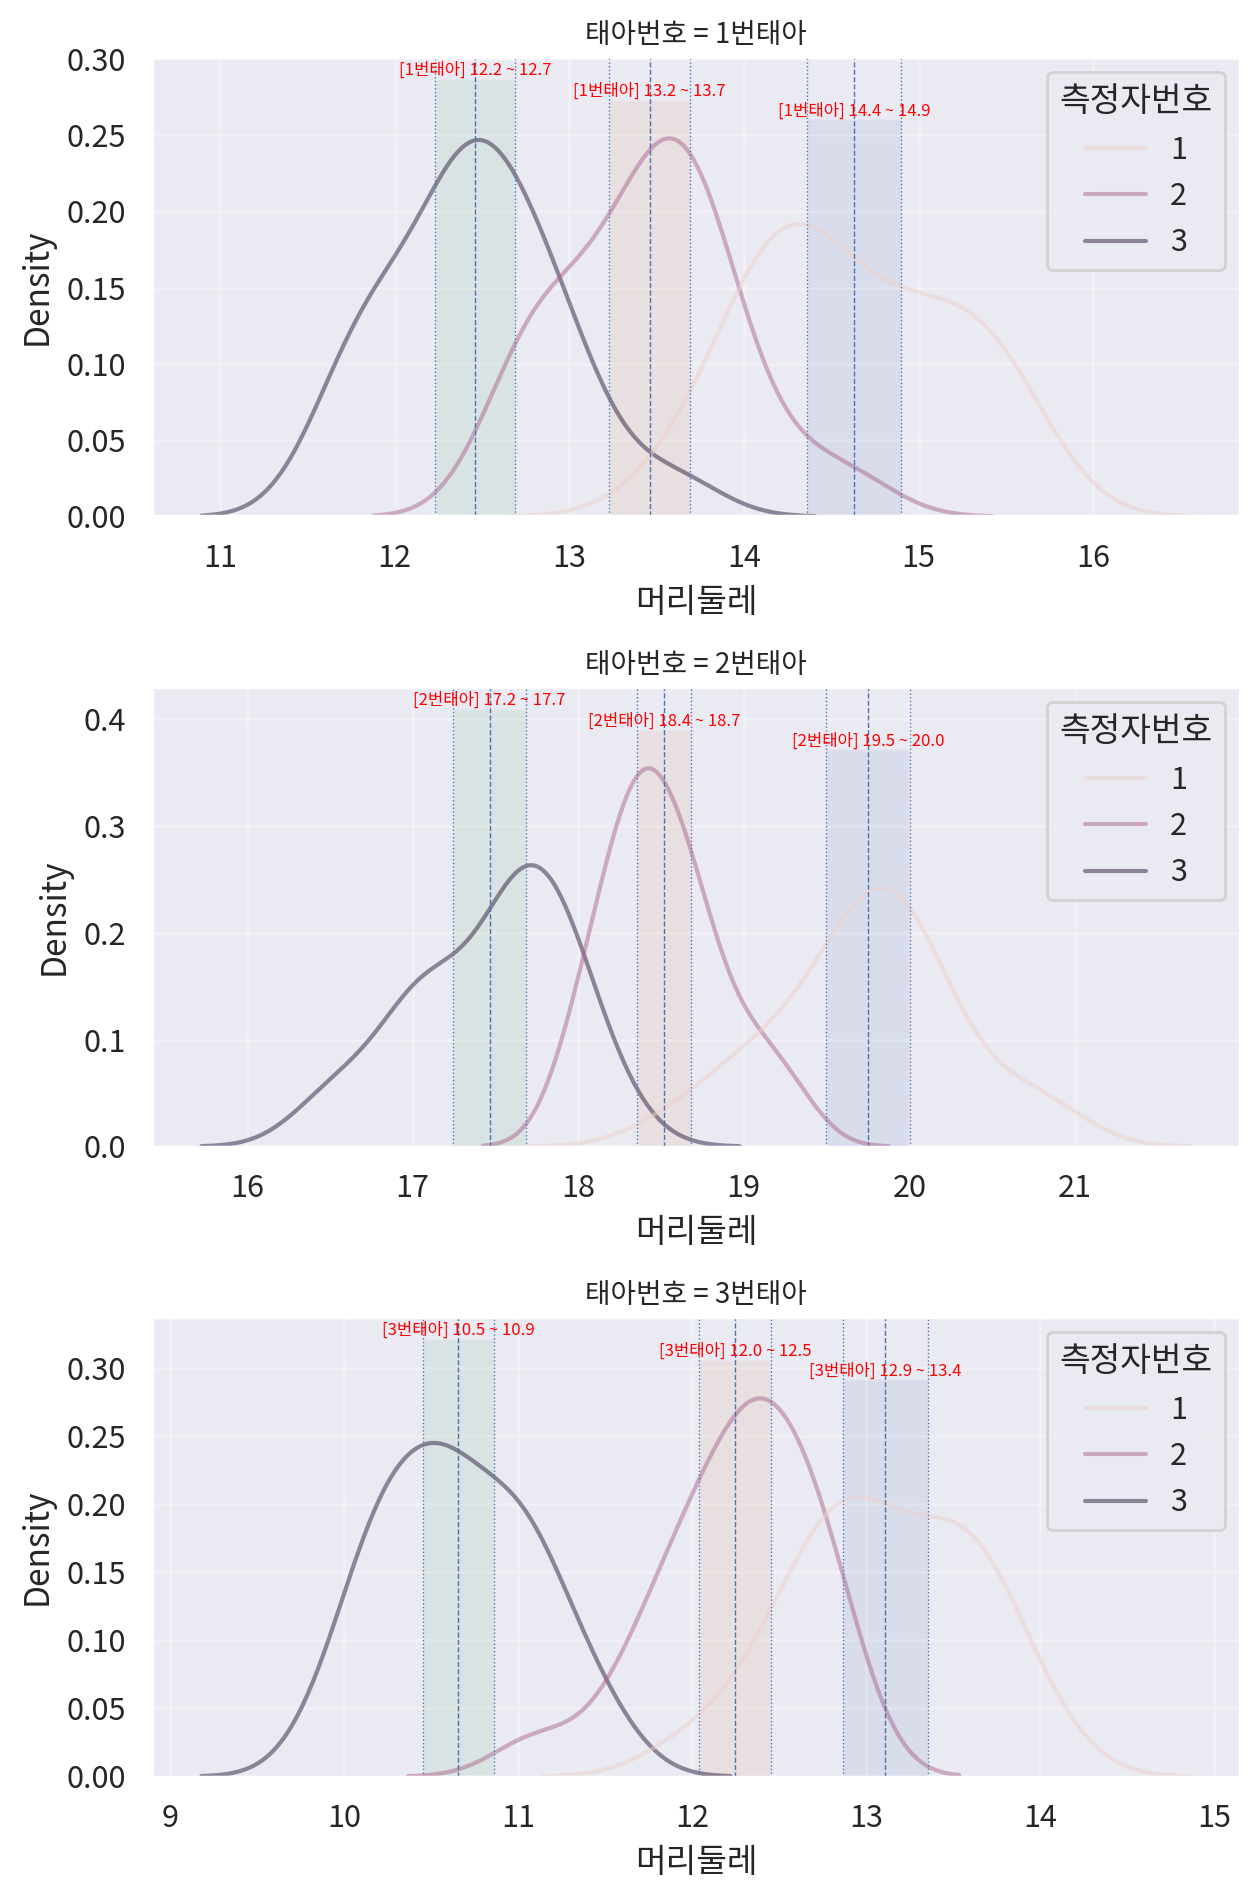

In [6]:
field = '머리둘레'
group_field = '태아번호'
hue_field = '측정자번호'

data =df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
rows = group_count               #도화지의 행 수
cols = 1                    #도화지의 열 수
width_px = 1280 * cols            #그래프 가로 크기
height_px = 640 * rows             #그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(group_values):
    temp = data[data[group_field]==v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field]==h]

        # 신뢰구간
        max = temp_sub[field].max()                         #최대값
        clevel = 0.95                               #신뢰수준
        dof = len(temp_sub[field]) - 1                       #자유도
        sp_mean = temp_sub[field].mean()                    #표본평균
        sp_std = temp_sub[field].std(ddof = 1)           #표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field])) #표본표준오차
        cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        #평균 표시
        ymin,ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

        #텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

가설 검정의 가정 확인

In [7]:
data = df.copy()
xname = ['측정자번호','태아번호']
yname = '머리둘레'

u1 = data[xname[0]].unique()    #첫 번째 독립변수의 범주들
u2 = data[xname[1]].unique()    #두 번째 독립변수의 범주들
# print(u1,u2)
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]]==i) & (data[xname[1]] == j)][yname]    #각 그룹별 데이터 추출
        equal_var_fields.append(filtered_data)
        s,p = normaltest(filtered_data)    #정규성 검정

        normalize = p>0.05
        report.append({
            "field": "{0}, {1}".format(i,j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s,p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s,p = levene(*equal_var_fields)

eqaul_var = p > 0.05

report.append({
    "field": "n",
    "statistic": s,
    "p-value": p,
    "result": eqaul_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
"1, 1번태아",1.885153,0.389623,True
"1, 2번태아",0.290183,0.864943,True
"1, 3번태아",0.408716,0.815171,True
"2, 1번태아",0.454973,0.796533,True
"2, 2번태아",1.442948,0.486035,True
"2, 3번태아",3.862339,0.144979,True
"3, 1번태아",0.666927,0.716438,True
"3, 2번태아",1.463170,0.481146,True
"3, 3번태아",0.846989,0.654755,True


분산 분석 수행

In [8]:
xname = ['측정자번호','태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

equal_var = p > 0.05

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)

display(pg_anova)

for idx in pg_anova.index[:-1]:
    row = pg_anova.iloc[idx]
    source=row['Source']
    p_val=row['p-unc']

    if p_val <= 0.05:
        print(f"-> {source}효과는 유의함. (대립가설 채택: p<=0.05)")
    else:
        print(f"-> {source}효과는 유의하지 않음. (귀무가설 채택: p>0.05)")

    


,Source,SS,DF,MS,F,p-unc,np2
0,측정자번호,159.320778,2,79.660389,336.822068,4.904107e-60,0.797548
1,태아번호,1422.825444,2,711.412722,3008.013241,5.616407e-134,0.972362
2,측정자번호 * 태아번호,2.201222,4,0.550306,2.326816,5.827850e-02,0.051619
3,Residual,40.442500,171,0.236506,NaN,NaN,NaN


-> 측정자번호효과는 유의함. (대립가설 채택: p<=0.05)
-> 태아번호효과는 유의함. (대립가설 채택: p<=0.05)
-> 측정자번호 * 태아번호효과는 유의하지 않음. (귀무가설 채택: p>0.05)


사후검정

In [9]:
xname = ['측정자번호', '태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

levels = {}

for factor in xname:
    level_count = data[factor].nunique()
    levels[factor] = level_count

pvals={}

for index, row in pg_anova.iterrows():
    source_name = row['Source']
    p_value = row['p-unc']
    pvals[source_name] = p_value

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <=2:
        print(f"-> {levels[factor]}수준이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor,None)
    if p_val is None:
        print("-> ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음(p={p_val:.3g}) -> 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의함(p={p_val:.3g}) -> 사후검정 수행")

    if equal_var:
        print(" - Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" - Games-Howell 사용 (등분산 미충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) -> 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음")


[측정자번호]
- 주효과 유의함(p=4.9e-60) -> 사후검정 수행
 - Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,15.830000,14.741667,1.088333,0.525341,2.071671,0.098702,0.380087
1,1,3,15.830000,13.526667,2.303333,0.525341,4.384456,0.000059,0.781644
2,2,3,14.741667,13.526667,1.215000,0.525341,2.312785,0.056613,0.422358



[태아번호]
- 주효과 유의함(p=5.62e-134) -> 사후검정 수행
 - Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1번태아,2번태아,13.516667,18.578333,-5.061667,0.195025,-25.953939,0.000000e+00,-4.841750
1,1번태아,3번태아,13.516667,12.003333,1.513333,0.195025,7.759689,1.915246e-12,1.393082
2,2번태아,3번태아,18.578333,12.003333,6.575000,0.195025,33.713629,0.000000e+00,6.016793



[측정자번호 * 태아번호] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.0583) -> 단순주효과 분석 필요 없음


연습문제1.
- poisons 데이터 셋은 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터이다.
- 사용된 독극물 종류와 치료 유형에 유의미한 차이가 있는지 분석하라.

In [10]:
origin = load_data('poisons')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/poisons.xlsx
[desc] 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터 (출처: 방송통신대학교 통계학 개론)

field    description
-------  ------------------
time     동물의 생존시간
poison   사용된 독극물 종류
treat    사용되는 치료 유형


===== 데이터 크기 확인 =====
데이터셋 크기 : (360, 3)
열 개수: 3
행 개수: 360

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    360 non-null    float64
 1   poison  360 non-null    object 
 2   treat   360 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.6+ KB
None


,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1


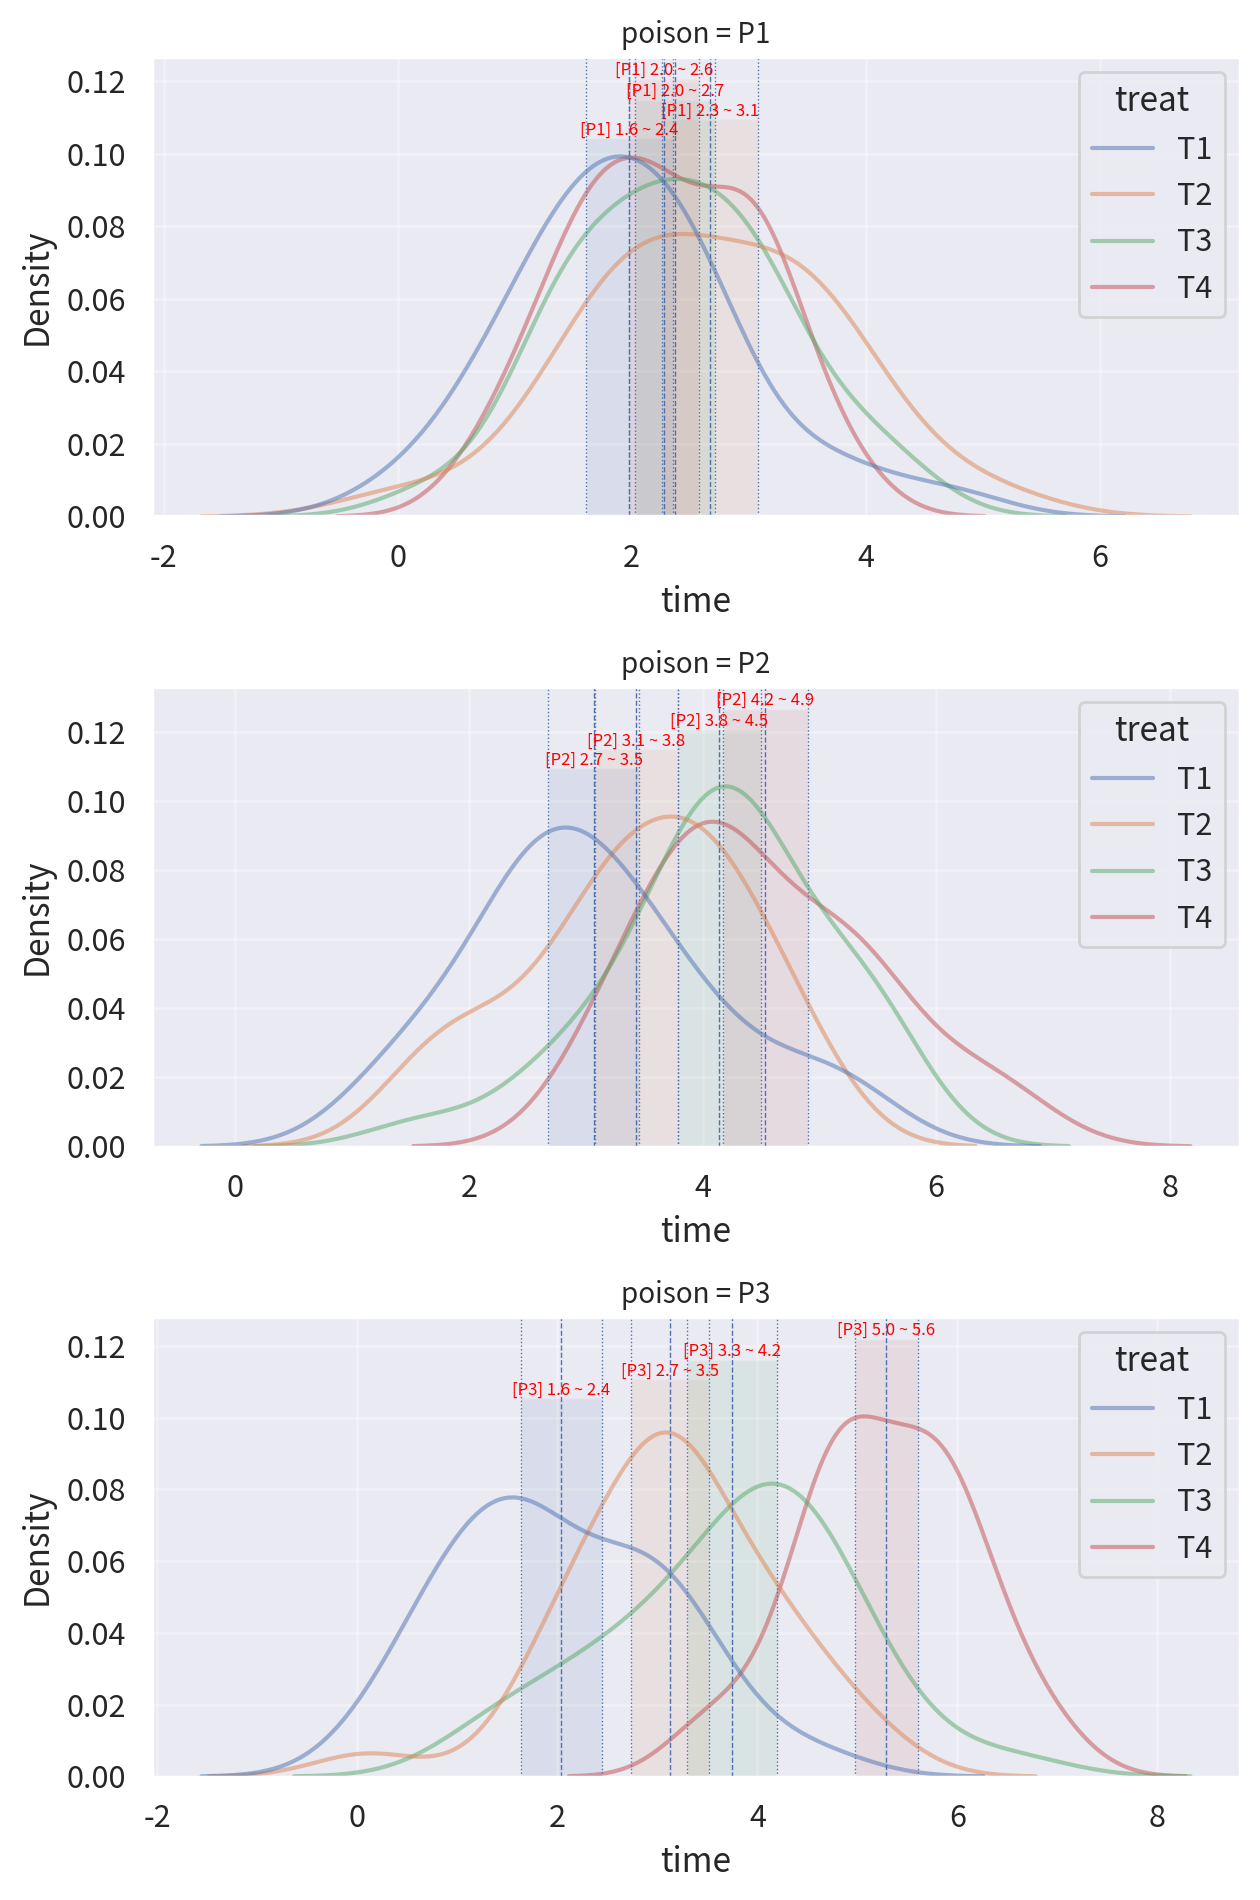

In [11]:
field = 'time'
group_field = 'poison'
hue_field = 'treat'

data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
rows = group_count               #도화지의 행 수
cols = 1                    #도화지의 열 수
width_px = 1280 * cols            #그래프 가로 크기
height_px = 640 * rows             #그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(group_values):
    temp = data[data[group_field]==v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field]==h]

        # 신뢰구간
        max = temp_sub[field].max()                         #최대값
        clevel = 0.95                               #신뢰수준
        dof = len(temp_sub[field]) - 1                       #자유도
        sp_mean = temp_sub[field].mean()                    #표본평균
        sp_std = temp_sub[field].std(ddof = 1)           #표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field])) #표본표준오차
        cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        #평균 표시
        ymin,ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

        #텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

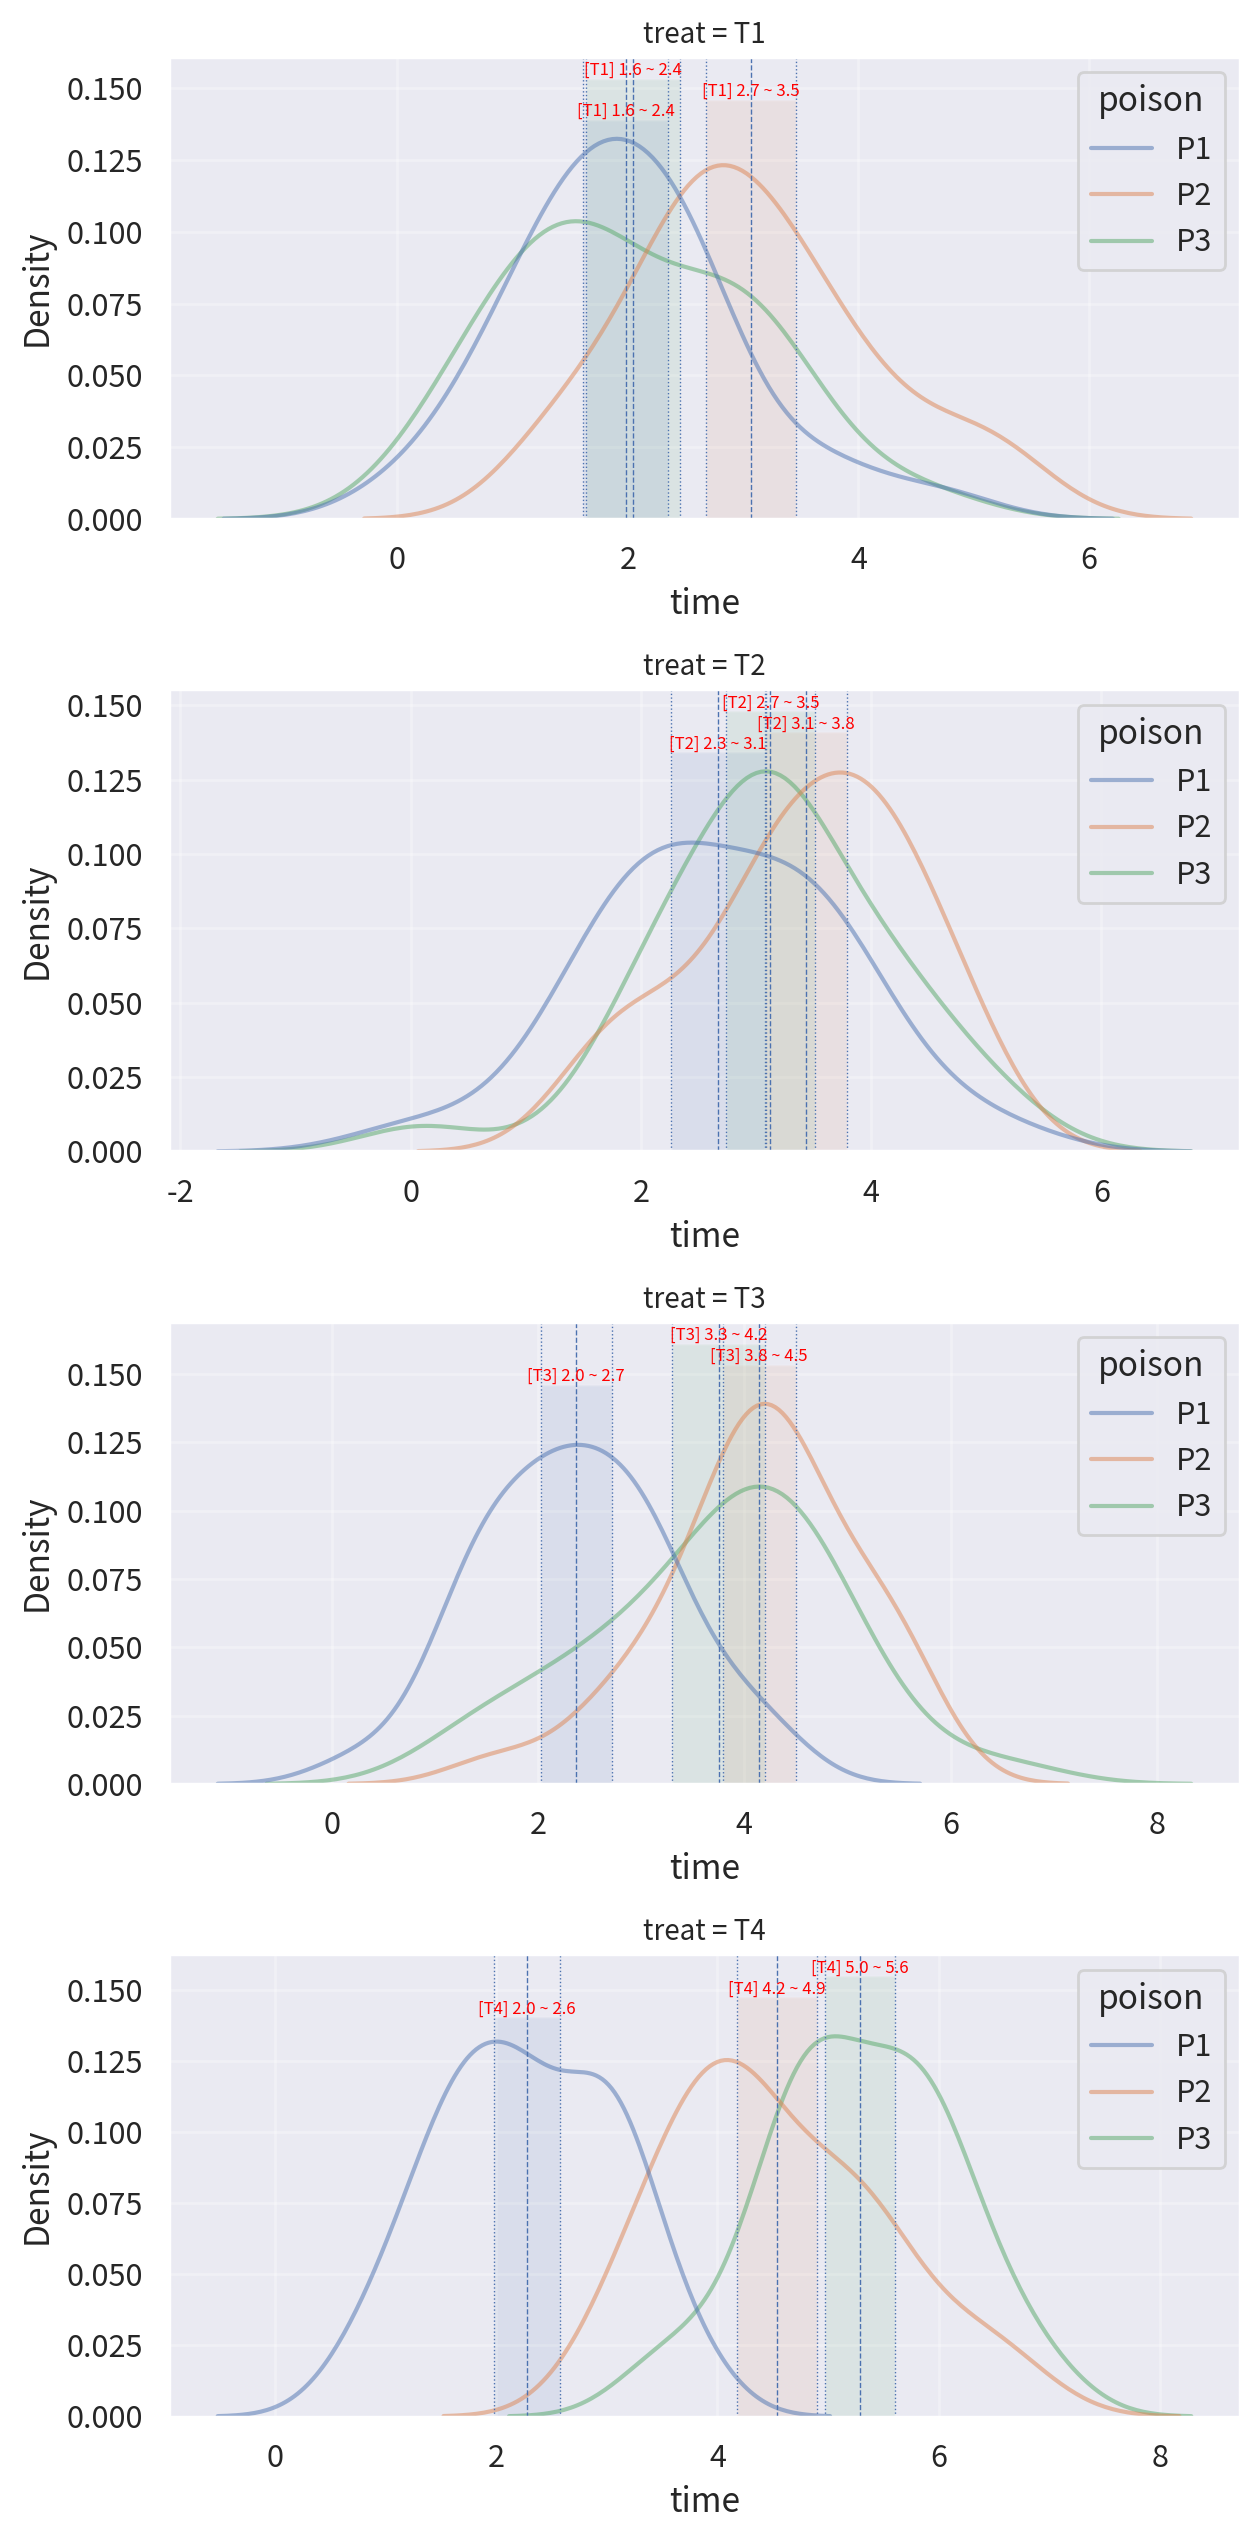

In [12]:
field = 'time'
group_field = 'treat'
hue_field = 'poison'

data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
rows = group_count               #도화지의 행 수
cols = 1                    #도화지의 열 수
width_px = 1280 * cols            #그래프 가로 크기
height_px = 640 * rows             #그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(group_values):
    temp = data[data[group_field]==v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field]==h]

        # 신뢰구간
        max = temp_sub[field].max()                         #최대값
        clevel = 0.95                               #신뢰수준
        dof = len(temp_sub[field]) - 1                       #자유도
        sp_mean = temp_sub[field].mean()                    #표본평균
        sp_std = temp_sub[field].std(ddof = 1)           #표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field])) #표본표준오차
        cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        #평균 표시
        ymin,ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

        #텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

In [13]:
data = origin.copy()
xname = ['poison','treat']
yname = 'time'

u1 = data[xname[0]].unique()    #첫 번째 독립변수의 범주들
u2 = data[xname[1]].unique()    #두 번째 독립변수의 범주들
# print(u1,u2)
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]]==i) & (data[xname[1]] == j)][yname]    #각 그룹별 데이터 추출
        equal_var_fields.append(filtered_data)
        s,p = normaltest(filtered_data)    #정규성 검정

        normalize = p>0.05
        report.append({
            "field": "{0}, {1}".format(i,j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s,p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s,p = levene(*equal_var_fields)

eqaul_var = p > 0.05

report.append({
    "field": "n",
    "statistic": s,
    "p-value": p,
    "result": eqaul_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
"P1, T1",3.660816,0.160348,True
"P1, T2",0.266462,0.875263,True
"P1, T3",0.014374,0.992839,True
"P1, T4",1.476194,0.478023,True
"P2, T1",1.112279,0.573418,True
"P2, T2",1.509951,0.470022,True
"P2, T3",2.802084,0.246340,True
"P2, T4",1.662054,0.435602,True
"P3, T1",0.837473,0.657878,True


In [14]:
xname = ['poison','treat']
yname = 'time'
data = origin[xname + [yname]]

equal_var = p > 0.05

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)

display(pg_anova)

for idx in pg_anova.index[:-1]:
    row = pg_anova.iloc[idx]
    source=row['Source']
    p_val=row['p-unc']

    if p_val <= 0.05:
        print(f"-> {source}효과는 유의함. (대립가설 채택: p<=0.05)")
    else:
        print(f"-> {source}효과는 유의하지 않음. (귀무가설 채택: p>0.05)")

    


,Source,SS,DF,MS,F,p-unc,np2
0,poison,148.976389,2,74.488194,74.722166,1.002877e-27,0.300424
1,treat,131.260972,3,43.753657,43.891090,4.430485e-24,0.274506
2,poison * treat,81.381611,6,13.563602,13.606206,6.938981e-14,0.190014
3,Residual,346.910333,348,0.996869,NaN,NaN,NaN


-> poison효과는 유의함. (대립가설 채택: p<=0.05)
-> treat효과는 유의함. (대립가설 채택: p<=0.05)
-> poison * treat효과는 유의함. (대립가설 채택: p<=0.05)


In [15]:
xname = ['poison', 'treat']
yname = 'time'
data = origin[xname + [yname]]

levels = {}

for factor in xname:
    level_count = data[factor].nunique()
    levels[factor] = level_count

pvals={}

for index, row in pg_anova.iterrows():
    source_name = row['Source']
    p_value = row['p-unc']
    pvals[source_name] = p_value

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <=2:
        print(f"-> {levels[factor]}수준이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor,None)
    if p_val is None:
        print("-> ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음(p={p_val:.3g}) -> 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의함(p={p_val:.3g}) -> 사후검정 수행")

    if equal_var:
        print(" - Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" - Games-Howell 사용 (등분산 미충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) -> 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음")


[poison]
- 주효과 유의함(p=1e-27) -> 사후검정 수행
 - Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,P1,P2,2.325000,3.795833,-1.470833,0.161626,-9.100235,5.107026e-14,-1.388884
1,P1,P3,2.325000,3.550000,-1.225000,0.161626,-7.579233,9.585666e-13,-0.931693
2,P2,P3,3.795833,3.550000,0.245833,0.161626,1.521002,2.822579e-01,0.179210



[treat]
- 주효과 유의함(p=4.43e-24) -> 사후검정 수행
 - Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,T1,T2,2.363333,3.075556,-0.712222,0.189827,-3.751957,1.168920e-03,-0.639750
1,T1,T3,2.363333,3.421111,-1.057778,0.189827,-5.572330,2.971230e-07,-0.867932
2,T1,T4,2.363333,4.034444,-1.671111,0.189827,-8.803345,6.006307e-14,-1.220199
3,T2,T3,3.075556,3.421111,-0.345556,0.189827,-1.820373,2.654092e-01,-0.292572
4,T2,T4,3.075556,4.034444,-0.958889,0.189827,-5.051387,4.181336e-06,-0.717648
5,T3,T4,3.421111,4.034444,-0.613333,0.189827,-3.231015,7.343056e-03,-0.430346



[poison * treat] 상호작용 효과
- 상호작용 유의 (p=6.94e-14) -> 단순주효과 분석 필요


### 인사이트

#### 1. 분석 목적
- 본 분석은 생존 시간에 대해 사용된 독극물 종류(poison)와 치료 유형(treat)이 어떤 영향을 미치는지를 평가하기 위해 이원분산분석(two-way ANOVA)을 수행하였다.

#### 2. 분산분석 주요 결과

2-1. 요인별 유의성 판단(유의수준 0.05 기준)
- 독극물 종류 : p<= 0.05 -> 유의함(대립가설 채택)
- 치료 유형 : p<= 0.05 -> 유의함(대립가설 채택)
- 독극물 종류 x 치료 유형 : p<= 0.05 -> 유의함(대립가설 채택)

요약 - 독극물과 치료 유형에 따라 생존 시간에 차이가 있으며 결합효과 또한 확인된다.

#### 3. 기술통계 및 집단별 평균 비교
- 독극물종류 수준별 평균
    - 독극물 1: 2.325
    - 독극물 2: 3.795
    - 독극물 3: 3.55
    -> 독극물 1에 대해서만 다른 독극물에 비해 평균이 유독 낮음
- 치료유형 수준별 평균
    - T1 : 2.363
    - T2 : 3.075
    - T3 : 3.421
    - T4 : 4.034
    -> 치료 유형에 따라 생존시간이 1초 이상 차이날 수 있음

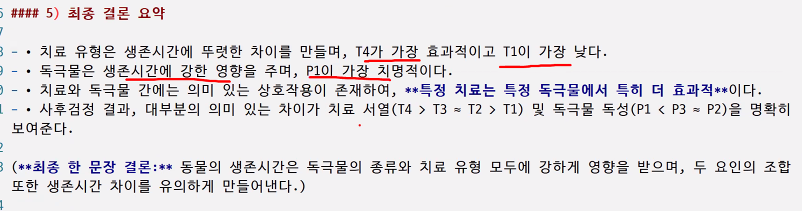

연습문제 2.
- tomato 데이터 셋은 효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지에 대한 실험 결과이다.
- 분산 분석을 하여 효소 함량에 따라 토마토 모종 성장에 차이가 나는 지 검정하라.

In [16]:
origin = load_data('tomato')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
 
print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/tomato.xlsx
[desc] 효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지에 대한 실험 결과 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (90, 2)
열 개수: 2
행 개수: 90

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   효소함량    90 non-null     int64  
 1   모종성장    90 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.5 KB
None


,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4


In [17]:
origin['효소함량'].unique()

array([   0,  100, 1000])

In [18]:
if equal_var:
    pg_anova = anova(data=origin, dv='모종성장', between=['효소함량'])
else:
    pg_anova = welch_anova(data=origin, dv='모종성장', between=['효소함량'])

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,효소함량,2,87,81.094169,1.318657e-20,0.650866


In [19]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")


'statistic: 81.094, p-value: 0.000, 대립가설 채택'

효소 함량이 모종 성장에 영향이 크다.

In [20]:
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=origin, dv='모종성장', between='효소함량')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(data=origin, dv='모종성장', between='효소함량')

hoc_df

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,100,10.753333,13.180000,-2.426667,0.338824,-7.162024,7.228520e-10,-1.867526
1,0,1000,10.753333,15.056667,-4.303333,0.338824,-12.700788,2.220446e-15,-3.315507
2,100,1000,13.180000,15.056667,-1.876667,0.338824,-5.538763,9.517362e-07,-1.350914


- 효소함량은 모종 성장에 유의한 차이가 존재한다.
- 효소함량간의 비교에서 평균 차이가 존재하고 이는 통계적으로 유의하다.
- 특히, 효소 함량이 0인것과 1000인것의 diff가 4.3으로 큰 평균 차이가 있다.


연습문제3.
- edu 데이터 셋은 두 가지 교육 방법을 비교하기 위하여 능력이 비슷한 고등학교 학생22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육 방법으로 교육시킨 후 치른 학기말 시험 성적을 조사한 자료이다.

- 이 자료를 이용하여 두 가지 교육방법에 대한 국어와 영어의 효과가 서로 다르다고 할 수 있는지 검정하라. (분석 목적에 맞는 데이터 재배치 과정이 필요)


In [21]:
origin = load_data('edu')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/edu.xlsx
[desc] 두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적을 조사한 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (22, 3)
열 개수: 3
행 개수: 22

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   교육방법    22 non-null     int64
 1   국어      22 non-null     int64
 2   영어      22 non-null     int64
dtypes: int64(3)
memory usage: 660.0 bytes
None


,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65


In [22]:
origin = origin.reset_index().rename(columns={'index': '학생ID'})
df = melt(origin, id_vars=['학생ID','교육방법'],
          value_vars=['국어', '영어'],
          var_name = '과목', value_name='점수')
df.head()

,학생ID,교육방법,과목,점수
0,0,1,국어,65
1,1,1,국어,87
2,2,1,국어,73
3,3,1,국어,79
4,4,1,국어,81


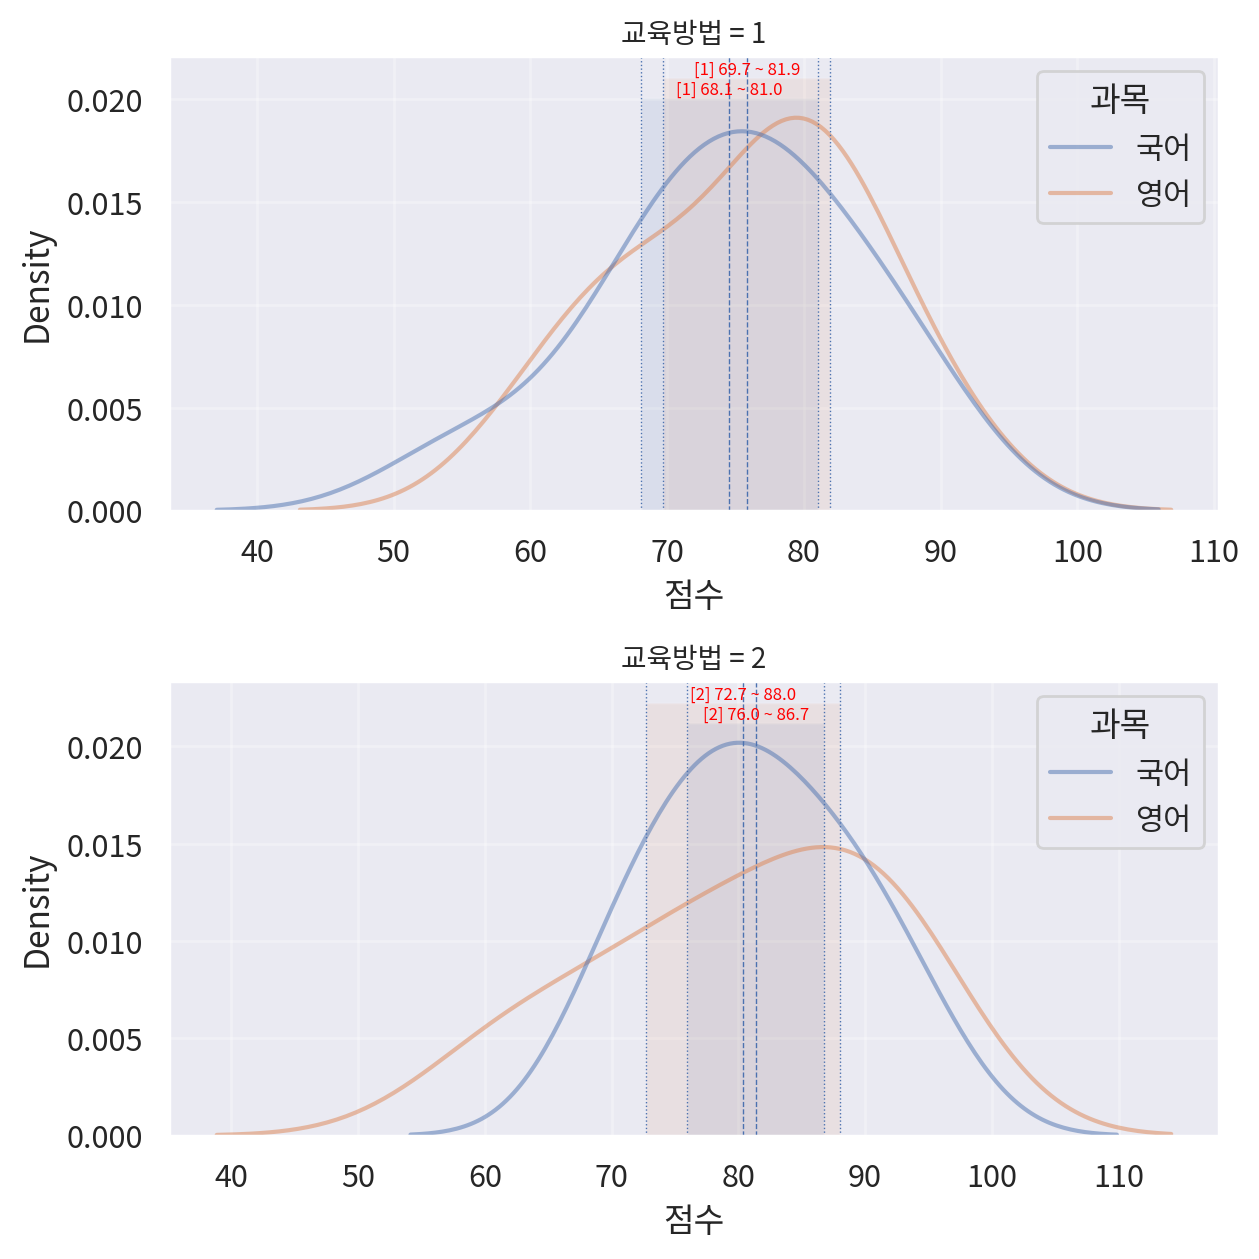

In [23]:
field = '점수'
group_field = '교육방법'
hue_field = '과목'

data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
rows = group_count               #도화지의 행 수
cols = 1                    #도화지의 열 수
width_px = 1280 * cols            #그래프 가로 크기
height_px = 640 * rows             #그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(group_values):
    temp = data[data[group_field]==v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize = 10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field]==h]

        # 신뢰구간
        max = temp_sub[field].max()                         #최대값
        clevel = 0.95                               #신뢰수준
        dof = len(temp_sub[field]) - 1                       #자유도
        sp_mean = temp_sub[field].mean()                    #표본평균
        sp_std = temp_sub[field].std(ddof = 1)           #표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field])) #표본표준오차
        cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        #평균 표시
        ymin,ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

        #텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 전체적으로 교육방법 2의 평균이 높음.
- 교육방법 1의 경우 국어와 영어 모두 75점에 몰려있음
- 교육방법 2의 경우 국어에 좀 더 강한 모습이 보여짐
- 교육방법 2의 경우 영어는 60점부터 100점까지 다양하게 분포함

In [24]:
data = df.copy()
xname = ['교육방법','과목']
yname = '점수'

u1 = data[xname[0]].unique()    #첫 번째 독립변수의 범주들
u2 = data[xname[1]].unique()    #두 번째 독립변수의 범주들
# print(u1,u2)
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]]==i) & (data[xname[1]] == j)][yname]    #각 그룹별 데이터 추출
        equal_var_fields.append(filtered_data)
        s,p = normaltest(filtered_data)    #정규성 검정

        normalize = p>0.05
        report.append({
            "field": "{0}, {1}".format(i,j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s,p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s,p = levene(*equal_var_fields)

eqaul_var = p > 0.05

report.append({
    "field": "n",
    "statistic": s,
    "p-value": p,
    "result": eqaul_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
"1, 국어",0.911351,0.634020,True
"1, 영어",0.389198,0.823165,True
"2, 국어",0.299661,0.860854,True
"2, 영어",1.094669,0.578490,True
n,2.871293,0.411898,True


굿 일반 anova ㄱㄱ

In [25]:
xname = ['교육방법','과목']
yname = '점수'
data = df[xname + [yname]]

equal_var = p > 0.05

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)

display(pg_anova)

for idx in pg_anova.index[:-1]:
    row = pg_anova.iloc[idx]
    source=row['Source']
    p_val=row['p-unc']

    if p_val <= 0.05:
        print(f"-> {source}효과는 유의함. (대립가설 채택: p<=0.05)")
    else:
        print(f"-> {source}효과는 유의하지 않음. (귀무가설 채택: p>0.05)")

    


,Source,SS,DF,MS,F,p-unc,np2
0,교육방법,355.113636,1,355.113636,3.845870,0.056857,0.087713
1,과목,0.204545,1,0.204545,0.002215,0.962695,0.000055
2,교육방법 * 과목,14.204545,1,14.204545,0.153835,0.696979,0.003831
3,Residual,3693.454545,40,92.336364,NaN,NaN,NaN


-> 교육방법효과는 유의하지 않음. (귀무가설 채택: p>0.05)
-> 과목효과는 유의하지 않음. (귀무가설 채택: p>0.05)
-> 교육방법 * 과목효과는 유의하지 않음. (귀무가설 채택: p>0.05)


- 학생들의 점수는 교육 방법에 차이가 크지않다 (귀무가설)
- 학생들의 점수는 과목에 차이가 크지 않다(귀무가설)
- 학생들의 점수는 교육방법 * 과목의 차이가 크지 않다(귀무가설)

교육방법에 따른 점수 차이나 과목에 따른 점수차이는 우연에 일치하고, 상호 작용 효과는 존재하지 않는다.

In [26]:
xname = ['과목', '교육방법']
yname = '점수'
data = df[xname + [yname]]

levels = {}

for factor in xname:
    level_count = data[factor].nunique()
    levels[factor] = level_count

pvals={}

for index, row in pg_anova.iterrows():
    source_name = row['Source']
    p_value = row['p-unc']
    pvals[source_name] = p_value

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <=2:
        print(f"-> {levels[factor]}수준이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor,None)
    if p_val is None:
        print("-> ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음(p={p_val:.3g}) -> 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의함(p={p_val:.3g}) -> 사후검정 수행")

    if equal_var:
        print(" - Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" - Games-Howell 사용 (등분산 미충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) -> 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) -> 단순주효과 분석 필요 없음")


[과목]
-> 2수준이므로 사후검정이 필요 없습니다.

[교육방법]
-> 2수준이므로 사후검정이 필요 없습니다.

[교육방법 * 과목] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.697) -> 단순주효과 분석 필요 없음
